# Importar librerias

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
print(os.listdir("./input"))


['.ipynb_checkpoints', 'sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


# Definir Constantes

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Preparar datos a entrenar

In [4]:
filenames = os.listdir("./input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### See Total In count

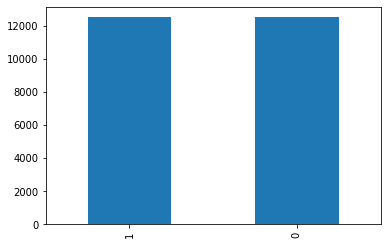

In [7]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# Ver imagen de ejemplo

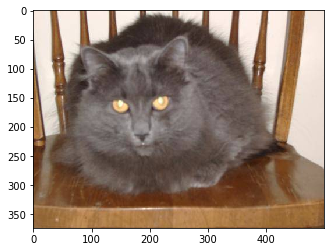

In [8]:
sample = random.choice(filenames)
image = load_img("./input/train/"+sample)
plt.imshow(image)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #adam optimizer

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

# Early Stop

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [12]:
earlystop = EarlyStopping(patience=10)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

# Preparar datos

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
train_df['category'] = train_df['category'].astype('str')
validate_df = validate_df.reset_index(drop=True)
validate_df['category'] = validate_df['category'].astype('str')

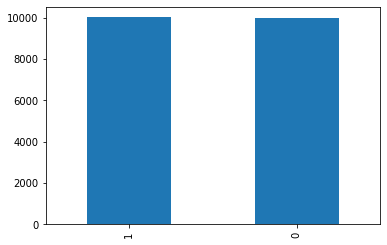

In [16]:
train_df['category'].value_counts().plot.bar()

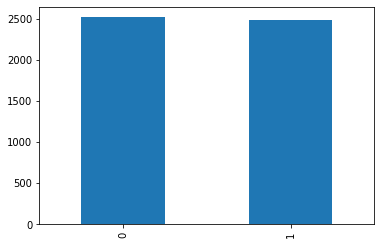

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=13

# Generador de entrenamiento

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Generador de validacion

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# Entrenando modelo

In [19]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1538/1538 [==============================] - 123s 80ms/step - loss: 0.6971 - acc: 0.6433 - val_loss: 0.5767 - val_acc: 0.7039
Epoch 2/50
1538/1538 [==============================] - 110s 72ms/step - loss: 0.5291 - acc: 0.7391 - val_loss: 0.5383 - val_acc: 0.7489
Epoch 3/50
1538/1538 [==============================] - 112s 73ms/step - loss: 0.4792 - acc: 0.7735 - val_loss: 0.3729 - val_acc: 0.8316
Epoch 4/50
1538/1538 [==============================] - 108s 70ms/step - loss: 0.4414 - acc: 0.7965 - val_loss: 0.4043 - val_acc: 0.8127

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
1538/1538 [==============================] - 108s 70ms/step - loss: 0.4048 - acc: 0.8180 - val_loss: 0.4079 - val_acc: 0.8249

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/50
1538/1538 [==============================] - 117s 76ms/step - loss: 0.3720 - acc: 0.8332 - val_loss: 0.3111 - val_acc: 0.8707
Epoch 7/50
1538/

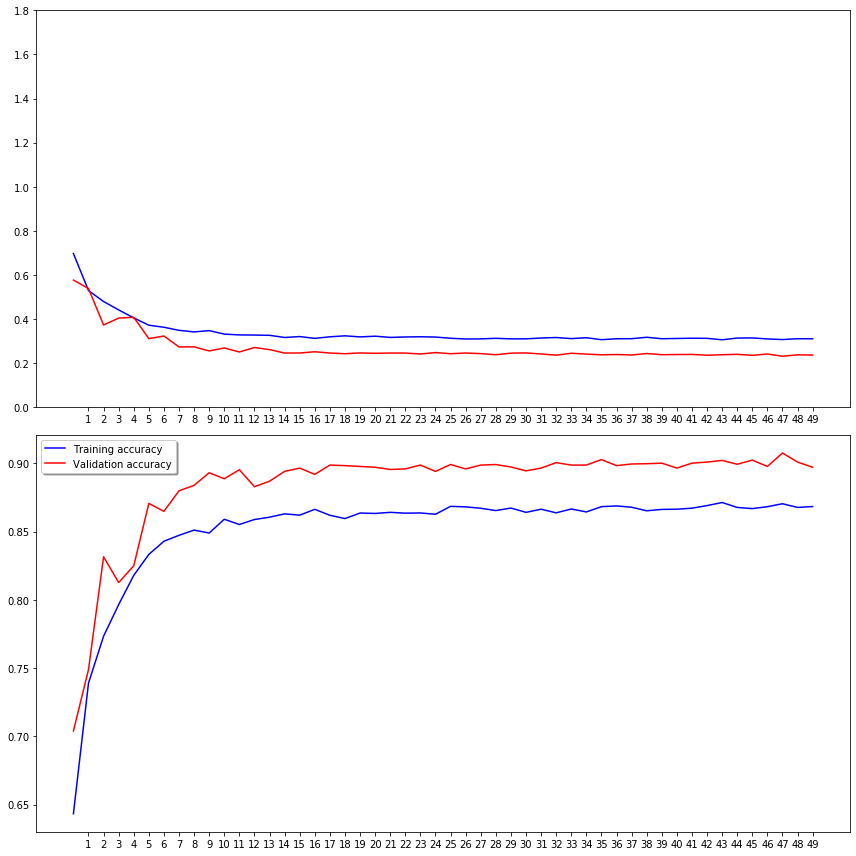

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.2))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.2))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Guardar modelo

In [28]:
model.save_weights("model.h5")

# Cargar modelo

In [21]:
model.load_weights("model.h5")

### Ver prediccion

In [22]:
from PIL import Image
import PIL
from keras.preprocessing import image

gato


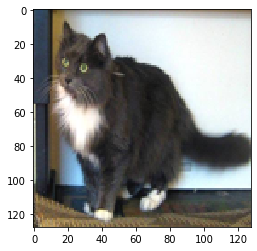

In [32]:
test_img=load_img(r"C:\Users\Dell\Desktop\Final Python\input\test1\9.jpg")
test_img= test_img.resize((128,128),resample=PIL.Image.BICUBIC)
test_arr=image.img_to_array(test_img)
test_arr=np.expand_dims(test_arr,axis=0)
test_arr /=255.0

plt.imshow(test_img)
score = float(model.predict(test_arr))

if score < 0.3:
    print("gato")
else:
        print("perro")

In [33]:

import anvil.server

anvil.server.connect("P4MWQ7IRRSRHGBBBHG4TBU7K-AG2NMWRX525CYHPP")


Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


In [36]:
import anvil.media
from PIL import Image
import PIL
from keras.preprocessing import image
@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = load_img(filename)
        img = img.resize((128, 128), resample=PIL.Image.BICUBIC)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr /= 255.0

        score = model.predict(arr)
        return ('Gato' if score < 0.3 else 'Perro',float(score))

